## 🔁 Looping in LangGraph – Iterative Workflow Design

This notebook demonstrates how to implement a controlled loop inside a LangGraph workflow.

Unlike simple sequential or conditional flows, looping allows:

- Iterative reasoning
- Re-evaluation of state
- Controlled repetition until a condition is met

The focus here is understanding how LangGraph handles state-driven loops.


In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain_groq import ChatGroq
import os
import operator

In [2]:
load_dotenv()

True

In [3]:
# Using high-reasoning models for evaluation and optimization
analyst_llm = ChatGroq(model="moonshotai/kimi-k2-instruct-0905", temperature=0.1)
manager_llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)
threat_intel_llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0.3)

### Define Incident Evaluation Schema

This Pydantic model defines the structured evaluation output.

It typically includes:

- Quality assessment
- Identified issues
- Improvement suggestions
- Approval status

Structured evaluation enables controlled looping decisions.

In [4]:
class IncidentEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_fix"] = Field(..., description="Is the report accurate and complete?")
    feedback: str = Field(..., description="Specific technical gaps or missing MITRE mappings.")

### Define Graph State

The state object represents shared memory across all nodes.

Each iteration:
- Reads the current state
- Modifies specific fields
- Passes the updated state forward

Loop control logic relies on state variables (e.g., counters or flags).


In [5]:
class SOCState(TypedDict):
    raw_logs: str
    report: str
    evaluation: Literal["approved", "needs_fix"]
    feedback: str
    iteration: int
    max_iteration: int
    report_history: Annotated[list[str], operator.add]

### Initial Draft Generation Node

This node generates the first version of the incident report.

Input:
- Raw security logs from the state

Output:
- Draft report stored in state

This represents the first analysis pass before refinement begins.

In [6]:
def draft_incident_report(state: SOCState):
    messages = [
        SystemMessage(content="You are a Tier-1 SOC Analyst. Your job is to turn raw logs into a structured incident report."),
        HumanMessage(content=f"Draft a report for these logs: {state['raw_logs']}. Include: Timeline, Source/Dest IP, and Severity.")
    ]
    response = analyst_llm.invoke(messages).content
    return {'report': response, 'report_history': [response]}

### Configure Structured Evaluation Model

Here we wrap the manager LLM with structured output using the `IncidentEvaluation` schema.

This ensures:

- Deterministic evaluation results
- Machine-readable audit decisions
- Reliable loop routing

In [7]:
structured_manager = manager_llm.with_structured_output(IncidentEvaluation)

def audit_report(state: SOCState):
    messages = [
        SystemMessage(content="You are a Senior SOC Manager. Audit reports for technical accuracy and MITRE ATT&CK alignment."),
        HumanMessage(content=f"Audit this report: {state['report']}. Reject if it lacks actionable containment steps or specific CVE/MITRE IDs.")
    ]
    response = structured_manager.invoke(messages)
    return {'evaluation': response.evaluation, 'feedback': response.feedback}

### Define Iterative Processing Node

This node represents the core logic executed during each loop iteration.

Responsibilities:
- Analyze current state
- Update relevant fields
- Increment iteration counter (if applicable)

The loop continues until a termination condition is satisfied.


In [8]:
def refine_report(state: SOCState):
    messages = [
        SystemMessage(content="You are a Threat Intelligence expert. Enhance reports with context and remediation advice."),
        HumanMessage(content=f"Refine this report based on feedback: {state['feedback']}\nOriginal: {state['report']}")
    ]
    response = threat_intel_llm.invoke(messages).content
    return {'report': response, 'iteration': state['iteration'] + 1, 'report_history': [response]}

### Audit-Based Routing Decision

This function determines whether:

- The report requires further refinement
- The workflow should terminate

Routing is based on structured evaluation results such as approval status or quality score.

This is the core loop control mechanism.

In [9]:
def route_audit(state: SOCState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    return 'needs_fix'

### Construct the Iterative Graph

We initialize a `StateGraph` using the defined SOCState schema.

All nodes and conditional edges will be registered within this graph.

In [10]:
graph = StateGraph(SOCState)

graph.add_node('draft', draft_incident_report)
graph.add_node('audit', audit_report)
graph.add_node('refine', refine_report)

graph.add_edge(START, 'draft')
graph.add_edge('draft', 'audit')
graph.add_conditional_edges('audit', route_audit, {
    'approved': END, 
    'needs_fix': 'refine'
})
graph.add_edge('refine', 'audit')

workflow = graph.compile()

### Compile the Workflow

The graph is compiled into an executable workflow object.

Compilation validates:

- Node connectivity
- Conditional routing logic
- State integrity

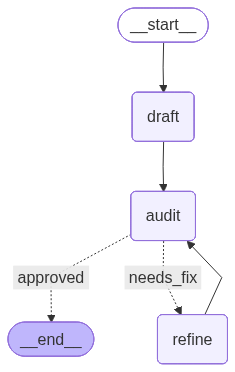

In [15]:
workflow

### Define Initial Input State

We create the initial state containing raw security logs.

This serves as the starting point for the drafting and iterative refinement process.

In [11]:
initial_logs = {
    "raw_logs": "2026-02-18 14:00:01 - Alert: Possible Brute Force. Src: 192.168.1.50, Dst: 10.0.0.5. 50 failed logins in 10s. User: admin.",
    "iteration": 1,
    "max_iteration": 3
}

result = workflow.invoke(initial_logs)

### Execute Workflow and Capture Result

We invoke the compiled workflow using the initial state.

Execution proceeds through:

1. Draft generation
2. Evaluation
3. Conditional refinement (loop)
4. Final approval

In [12]:
result

{'raw_logs': '2026-02-18 14:00:01 - Alert: Possible Brute Force. Src: 192.168.1.50, Dst: 10.0.0.5. 50 failed logins in 10s. User: admin.',
 'report': '**Incident Report – Tier‑1 SOC (Re‑vised)**  \n**Date:** 2026‑02‑18\u202f14:05\u202fUTC  \n\n---  \n\n## 1. Executive Summary  \n\nA rapid, high‑volume brute‑force authentication attempt was observed against the privileged **admin** account on **host\u202f10.0.0.5**. Within a 10‑second window, **50** consecutive failed logins originated from the internal workstation **192.168.1.50**.  \n\n*Primary ATT&CK mapping* – **T1110.001 – Password Guessing** (Credential Access).  \nIf the password were obtained, the adversary could subsequently use the credential as a **Valid Account** (**T1078**).  \n\nNo evidence was found for any defense‑evasion activity (e.g., disabling tools) or for exploitation of a public‑facing service. The only observable follow‑on behavior that could be leveraged by the attacker is **account‑lockout manipulation** (**T10

### Display Final Approved Report

We print the final version of the incident report after all refinement cycles are complete.

In [13]:
print(result['report'])

**Incident Report – Tier‑1 SOC (Re‑vised)**  
**Date:** 2026‑02‑18 14:05 UTC  

---  

## 1. Executive Summary  

A rapid, high‑volume brute‑force authentication attempt was observed against the privileged **admin** account on **host 10.0.0.5**. Within a 10‑second window, **50** consecutive failed logins originated from the internal workstation **192.168.1.50**.  

*Primary ATT&CK mapping* – **T1110.001 – Password Guessing** (Credential Access).  
If the password were obtained, the adversary could subsequently use the credential as a **Valid Account** (**T1078**).  

No evidence was found for any defense‑evasion activity (e.g., disabling tools) or for exploitation of a public‑facing service. The only observable follow‑on behavior that could be leveraged by the attacker is **account‑lockout manipulation** (**T1098.005 – Account Lockout**), which we now address explicitly.

---  

## 2. Detailed Timeline (UTC)

| Time (UTC) | Event |
|------------|-------|
| **14:00:01** | First failed l

### Review Iterative Report History

This loop displays all intermediate report versions generated during refinement.

It allows us to observe:

- How the report evolved
- Improvements across iterations
- Effectiveness of structured evaluation

In [14]:
for report in result['report_history']:
    print(report)

Incident Report – Tier-1 SOC  
Date: 2026-02-18 14:05

1. Summary  
A brute-force attack was detected against the admin account on host 10.0.0.5. Fifty consecutive failed login attempts originated from internal host 192.168.1.50 within a 10-second window.

2. Timeline (all times UTC)  
• 2026-02-18 14:00:01 – First failed login observed  
• 2026-02-18 14:00:11 – Threshold of 50 failures reached; alert generated

3. Source / Destination  
• Source IP: 192.168.1.50 (internal)  
• Destination IP: 10.0.0.5 (internal)

4. Severity  
High – rapid, high-volume authentication failures indicate active brute-force attempt; potential for account lockout or compromise if successful.

5. Recommended Next Actions  
• Verify if 192.168.1.50 is a compromised endpoint.  
• Temporarily block or rate-limit traffic from 192.168.1.50 → 10.0.0.5.  
• Force password reset for admin account and review successful logins post-alert.  
• Escalate to Tier-2 for deeper investigation and possible containment.
**Inc